In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.txt','\t')

In [14]:
normalized_data = data.copy()
# normalize X
high = data['X'].max()
low = data['X'].min()
normalized_data['X'] = ((data['X'] - low) / (high - low)) * 10 # within [-0.1,0.1]

# normalize Y
high = data['Y'].max()
low = data['Y'].min()
normalized_data['Y'] = ((data['Y'] - low) / (high - low)) * 10 # within [-0.1,0.1]

# timestamp / 40
normalized_data['timestamp'] = (data['timestamp'] / 40).map(int)

In [15]:
normalized_data.to_csv('data_normalized.csv')

In [16]:
# functions for generate a batch of sample
'''
    Input:
        data: the CSV
        num_data: size of batch
    Output:
        IDs: list of selected IDs
        input_sequence: batch with shape (num_data,input_length, 2)
        output_sequence: batch with shape (num_data, output_length, 2)
'''
from random import shuffle
def get_batch(data,num_data = 16,input_length = 8, output_length = 4):
    # evaluate the total length of series required
    total_length = input_length + output_length
    # filter out the series that has at least the number of `total_length` long
    id_counts = data.groupby('ID').ID.count()
    # get a table of candidate id, whose sequence is longer than (or eq. to) total_length
    candidate_id_counts = id_counts[id_counts >= total_length]
    # the number of candidates...
    total_candidate_id_count = candidate_id_counts.count()
    # get the random sequence...
    random_ids_selected = [i for i in range(total_candidate_id_count)]
    shuffle(random_ids_selected)
    
    selected_ids = []
    input_batch = []
    target_batch = []
    # retrieve the coordinates of the sequence (from the beginning to `total_length`)
    for i in random_ids_selected[:num_data]:
        selected_ids.append(i)
        # select X,Y from ID where ID == i order by timestamp...
        sequence_of_i = data[data.ID == i].sort_values(by = "timestamp")[["X","Y"]]
        # divide the sequence into two parts...
        input_sequence = sequence_of_i.iloc[:input_length]
        target_sequence = sequence_of_i.iloc[input_length:total_length]
        # and append the new sequence to existing arrays
        input_batch.append(np.array(input_sequence))
        target_batch.append(np.array(target_sequence))
    
    # return and array of selected ids as well as the batch...
    return np.stack(selected_ids), np.stack(input_batch), np.stack(target_batch)
    

# verify the shape is right...
list(map(lambda a: a.shape,get_batch(normalized_data)))
    

[(16,), (16, 8, 2), (16, 4, 2)]

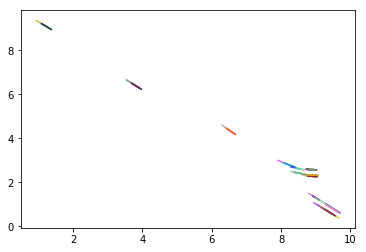

In [17]:
'''
    Visualize the traces in a batch
    If batch size = B, sequence length = L...
    Input:
        batch: batch of sequence of arbitrary length, i.e. array of shape (B,L,2)
    Output:
        None, a graph will be drawn instead..
'''

import matplotlib.pyplot as plt
def visualize_trace(batch,target_batch):
    # first we make sure that the shape of the batch looks like (_, _, 2)
    def check_shape(shape):
        if len(shape) != 3:
            raise ValueError("batch should be in 3 dimension")
        if shape[-1] != 2:
            raise ValueError("Last axis should be storing X,Y coordinates")
    
    check_shape(batch.shape)
    check_shape(target_batch.shape)
    # sub-routine for draw a particular batch
    def draw_batch(batch,linestyle = None):
        # now extract the dimension
        batch_size, sequence_length, _ = batch.shape
        for batch_id in range(batch_size):
            # pick a random color for this trace
            line_color = np.random.rand(3)
            for sequence_pos in range(sequence_length - 1):
                # get the two adjacent coordinates
                cur_coord = batch[batch_id, sequence_pos]
                next_coord = batch[batch_id, sequence_pos + 1]
                # and draw the line...
                # sneaky plot function requires x-coordinates to be put in the same argument, so are y-coordinates...
                plt.plot([cur_coord[0],next_coord[0]],
                         [cur_coord[1],next_coord[1]],
                         linestyle = linestyle,
                         c = line_color)
    
    draw_batch(batch)
    draw_batch(target_batch, ":")
    # finally show the graph
#     plt.show()
    
# let's test this visualization,
_, input_batch, target_batch = get_batch(normalized_data,16,16,8)
visualize_trace(input_batch,target_batch)

In [18]:
# now lets define a vanilla LSTM model
'''
    According to the paper, there should be an RNN that takes a sequence and gives a sequence (like seq-to-seq)
    except this output are hidden layers, like vectors of length 128
    To interpret such result, a dense layer with ReLU is added to condense the output to 5 numbers,
    namely, the mean_x, mean_y, sxx, syy, and sxy 
    of the bivariate gaussian of the probability of the agent at that given timestamp.
    
    The negative log likelihood between the real coordinate and this estimated distribution will be the loss.
'''
# first, the loss function, in Keras backend
from keras.layers import *
import keras.backend as K
'''
    The function takes a series of params of bivariate normal distribution, and a batch of observed coordinates,
    and return the log likelikhood of them...
    
    probability (likelihood) of the observed point (x,y) given the 5 parameters (mx,my,sx,sy,sp):
        det(2 * pi * [[sx,sp],[sp,sy]]) ^(-0.5) 
            * exp(-0.5 * ((x,y) - (mx,my)).T * [[sx,sp],[sp,sy]] * ((x,y) - (mx,my)))
    
    after taking log and add a minus (* -1)...
        -( (-0.5 * log(4 * pi ^ 2 * sx * sy - sp * sp)) + (-0.5 * (...)))
    
    If batch size = B, sequence length = D...
    Input:
        Batch bivariate parameters (estimated): K.variable with shape (B,D,5),
        Batch of overserved coordinates (label): K.variable with shape (B,D,2)
    
    Output:
        a scaler (K.variable with shape ()), which is the sum of negative log likelihood
'''

def negative_log_likelihood_loss(batch_observed_coordinates,batch_bivariate_params):
    # first check the dimension...
    input_shape = K.int_shape(batch_bivariate_params)
    target_shape = K.int_shape(batch_observed_coordinates)
    
    if len(input_shape) != 3 or len(target_shape) != 3:
        raise ValueError("Dimension of both tensors should be 3")
    
    if input_shape[0] != target_shape[0]:
        raise ValueError("Batch size of both tensors should be the same")
    
    if input_shape[1] != target_shape[1]:
        raise ValueError("Sequence length of both tensors should be the same")
    
    if input_shape[2] != 5:
        raise ValueError("Number of predicted parameters should be 5. Namely, (mx,my,sx,sy,sp)")
    
    if target_shape[2] != 2:
        raise ValueError("Dimension of target coordinates should be 2. Namely, (x,y)")
    
    # then split the tensors into (mx,my,sx,sy,sp)...
    # all of them should be of shape (B,D)
    batch_mx = batch_bivariate_params[:,:,0]
    batch_my = batch_bivariate_params[:,:,1]
    batch_sx = batch_bivariate_params[:,:,2]
    batch_sy = batch_bivariate_params[:,:,3]
    batch_sp = batch_bivariate_params[:,:,4]
    
    batch_x = batch_observed_coordinates[:,:,0]
    batch_y = batch_observed_coordinates[:,:,1]
    
    dx = batch_x - batch_mx # (B,D), (x - mx)
    dy = batch_y - batch_my # (B,D), (y - my)
    dydx = Multiply()([dx,dy])
    
    batch_x_change =  K.concatenate([batch_mx[:,0:1], batch_mx[:,1:] - batch_mx[:,:-1]])
    batch_y_change =  K.concatenate([batch_my[:,0:1], batch_my[:,1:] - batch_my[:,:-1]])
    target_x_change =  K.concatenate([batch_x[:,0:1], batch_x[:,1:] - batch_x[:,:-1]])
    target_y_change =  K.concatenate([batch_y[:,0:1], batch_y[:,1:] - batch_y[:,:-1]])
    
    xy_dot = Multiply()([batch_x_change,target_x_change]) + Multiply()([batch_y_change,target_y_change])
    batch_change_norm = K.sqrt(K.square(batch_x_change) + K.square(batch_y_change))
    target_change_norm = K.sqrt(K.square(target_x_change) + K.square(target_y_change))
    
    norm_prod = Multiply()([batch_change_norm,target_change_norm]) + 1e-6
    norm_prod_inv = K.pow(norm_prod,-1) # for numerical stability
    direction_loss =  - K.mean(Multiply()([xy_dot,norm_prod_inv]))
#     det_inv = K.print_tensor(K.pow(det,-1), message="det_inv") # (B,D), (sx * sy - sp^2) ^-1
    # (B,D), (dx^2 * sy - 2 * sp * dy * dx + sx * dy^2)
    exp = -0.5 * Multiply()([K.square(dx),batch_sy]) - 2 * Multiply()([dydx, batch_sp]) + Multiply()([K.square(dy),batch_sx])
    # (B,D), -0.5 * (dx^2 * sy - 2 * sp * dy * dx + sx * dy^2) * det(Cov)^(-1)
#     exp = Multiply()([det_inv,exp]) * (-0.5)
    
    # evaluate the final NLL
    '''
        A remark here: it is determined that the determininat of the covariance matrix will not be considered as a loss,
        as the value of that generally became very large (under the log function)
        therefore only the exponents are used as the loss
    '''
#     batch_nll = - (exp)
    batch_nll = K.square(dx) + K.square(dy) - 0.1 * exp + 0.1 * direction_loss
    batch_error_total = K.sum(batch_nll, axis = 1) # (B,) sum of NLL in a sequence...
    return K.print_tensor(K.mean(batch_error_total, axis = 0)) # (), average of sum of NLL...

# now test it...
# a regular 0-centered, non-skewing normal
[mx,my,sx,sy,sp] = [0,0,.1,.1,0.]
bivariate_params = np.array([[[mx,my,sx,sy,sp]]]) # (1,1,5)
target_point = np.array([[[-0.,0]]]) # (1,1,2)

bivariate_ph = K.variable(value = bivariate_params, dtype = "float32")
target_ph = K.variable(value = target_point, dtype = "float32")
nll = negative_log_likelihood_loss(target_ph,bivariate_ph)
K.eval(nll)

0.0

In [25]:
def infer_layer(batch_predicted_coordinates):
    return K.cumsum(batch_predicted_coordinates,axis = 1)
    
def check_tensor(batch_observed_coordinates,batch_predicted_coordinates):
    input_shape = K.int_shape(batch_predicted_coordinates)
    target_shape = K.int_shape(batch_observed_coordinates)

    if len(input_shape) != 3 or len(target_shape) != 3:
        raise ValueError("Dimension of both tensors should be 3")

    if input_shape[0] != target_shape[0]:
        raise ValueError("Batch size of both tensors should be the same")

    if input_shape[1] != target_shape[1]:
        raise ValueError("Sequence length of both tensors should be the same")

    if input_shape[2] != 2:
        raise ValueError("Number of predicted parameters should be 2. Namely, (mx,my)")

    if target_shape[2] != 2:
        raise ValueError("Dimension of target coordinates should be 2. Namely, (x,y)")
    
def ms_loss(input_tensor):
    batch_observed_coordinates,batch_predicted_coordinates = input_tensor
    # first check the dimension...
    check_tensor(batch_observed_coordinates,batch_predicted_coordinates)
    
    diff = K.square(batch_predicted_coordinates - batch_observed_coordinates)

    return K.sum(diff)

def dir_loss(input_tensor):
    batch_observed_coordinates,batch_predicted_coordinates = input_tensor
    check_tensor(batch_observed_coordinates,batch_predicted_coordinates)
    
    predict_dir = batch_predicted_coordinates[:,1:] - batch_predicted_coordinates[:,:-1]
    
    target_dir = batch_observed_coordinates[:,1:] - batch_observed_coordinates[:,:-1]
    
#     predic_dir_norm = 
    # this is to maximize the cosine (therefore angle = 0)
    return K.sum(K.square((predict_dir - target_dir)))

In [26]:
# then, the Vanilla LSTM
from keras.models import Model
from keras.initializers import RandomNormal
from keras import optimizers
def vanilla_lstm_model(num_hidden, input_length, predict_length, lr = 1e-3):
# def vanilla_lstm_model(num_hidden,input_length, predict_length, input_tensor, target_tensor):
    total_length = input_length + predict_length
    # the input
    input_sequence = Input(shape = (total_length,2), name = 'input_sequence', dtype = 'float32') # (T, 2)
    target_sequence = Input(shape = (total_length,2), name = 'target_sequence', dtype = 'float32') # (T, 2)
    lstm = LSTM(num_hidden, return_sequences = True)(input_sequence) # (B,T,num_hidden)
#     params = TimeDistributed(Dense(5, activation = 'elu'), name = 'params')(lstm) # (B,T,5)
    predicted_coordinates_raw = TimeDistributed(Dense(2, activation = 'elu'), name = 'params')(lstm)
    
    # retrieve the prediction
    extract_target_sequence_layer = Lambda(lambda x: x[:,input_length:,:])
    predicted_coordinates_masked = extract_target_sequence_layer(predicted_coordinates_raw)
    target_coordinates_masked = extract_target_sequence_layer(target_sequence)
    # the output layer
    predicted_output = Lambda(infer_layer, name = "predict")(predicted_coordinates_masked)
    # compute the loss
    
    # first part: the square loss
    sq_loss = Lambda(ms_loss, name = 'square_loss')([target_coordinates_masked, predicted_output])
    # second part: the direction loss
    ori_loss = Lambda(dir_loss, name = 'dir_loss')([target_coordinates_masked, predicted_output])
    
    loss = Lambda(lambda ts: ts[0] + ts[1],name = 'loss')([sq_loss, ori_loss])
    
    model = Model(
        inputs = [input_sequence,target_sequence],
        outputs = [predicted_output,loss])
    
    model.compile(optimizer=optimizers.RMSprop(lr = lr, clipvalue = 10., decay = 1e-6),
                  # since there are two outputs of the model, the estimated params and the NLL,
                  # their loss value should be specified.
                  # for params there are no loss regarding its value, but I just assign a zero as loss (or the computational graph will break)
                  # I made it loss - loss = 0.
                  # and for the NLL, return the loss as-is.
                  loss= {
                        'predict': lambda _, loss: loss - loss, # meh...
                          'loss': lambda _, loss: loss
                    })
    
    return input_sequence, target_sequence, model, predicted_output,loss




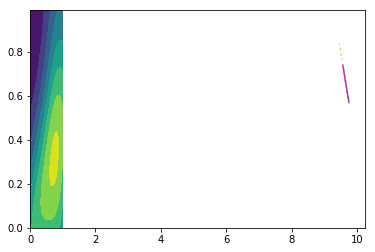

In [23]:
# helper function for monitoring training progress
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
'''
    Given a set of parameter (array of 5), visualize the heatmap of the bivariate normal distribution
'''
def draw_heatmap(params):
    resolution = 100
    interval = 1. / resolution
    
    x,y = np.mgrid[0:1:interval,0:1:interval]
    pos = np.empty(x.shape + (2,))
    pos[:,:,0] = x
    pos[:,:,1] = y
    result_distribution = None
    for param in params:
        mx,my,sx,sy,sp = param
        F = multivariate_normal([mx,my],[[sx,sp],[sp,sy]])
        result_distribution = F.pdf(pos) if result_distribution is None else result_distribution + F.pdf(pos)
    plt.contourf(x,y,result_distribution)

# try it out
# fig = plt.figure()
draw_heatmap(np.array([[0.3,0.1,0.4,0.2,.2],[0.9,0.2,0.1,0.9,0.]]))
visualize_trace(input_batch,target_batch)
# draw_heatmap(0.3,0.2,0.01,0.2,0.,fig)
plt.show()

'''
    Draw the mean of the predicted params of all timestamps
'''
import matplotlib.cm as cm
def draw_mean(params):
    plt.xlim(0,10)
    plt.ylim(0,10)
    
    
    for batch in range(params.shape[0]):
        line_color = np.random.rand(3) # choose a color to tell that these scatter points belong to the same prediction
        xy_series = params[batch,:,:] # (D,2)
        # prgressively change the color to indicate the direction
        colors = cm.rainbow(np.linspace(0, 1, params.shape[1]))
        plt.scatter(xy_series[:,0],xy_series[:,1], c = colors)

In [39]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, LambdaCallback

def get_callbacks(input_batch_padded,target_batch_padded,finetune = False):
    # prepare callbacks
    reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                  factor=0.1,
                                  patience=50, 
                                  min_lr=1e-6)
    csv_logger = CSVLogger("log.csv")

    def visualize_prediction(epoch, logs):
        params, loss = model.predict([input_batch_padded,target_batch_padded])
        # visualize the trace, as well as the distributions generated by the params...
        # first clear the previous drawing...
    #     try:
        plt.gcf().clear()
        visualize_trace(input_batch,target_batch)
    #     params = params[:,INPUT_LENGTH + 1, :] # (B,5), and it should be the params immediately after the input
    #     draw_heatmap(params)
        draw_mean(params)
        filename = '{}.png' if not finetune else '{}-finetune.png'
        plt.savefig(filename.format(epoch))

    plot_callback = LambdaCallback(on_epoch_begin = visualize_prediction)
    
    return [reduce_lr, csv_logger, plot_callback]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sequence (InputLayer)     (None, 12, 2)        0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 12, 128)      67072       input_sequence[0][0]             
__________________________________________________________________________________________________
params (TimeDistributed)        (None, 12, 2)        258         lstm_9[0][0]                     
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 4, 2)         0           params[0][0]                     
                                                                 target_sequence[0][0]            
__________

Epoch 43/500
16/16 [==============================] - 1s 50ms/step - loss: 599.1645 - predict_loss: 0.0000e+00 - loss_loss: 599.1645
Epoch 44/500
16/16 [==============================] - 1s 56ms/step - loss: 532.7977 - predict_loss: 0.0000e+00 - loss_loss: 532.7977
Epoch 45/500
16/16 [==============================] - 1s 66ms/step - loss: 588.0632 - predict_loss: 0.0000e+00 - loss_loss: 588.0632
Epoch 46/500
16/16 [==============================] - 1s 53ms/step - loss: 516.4918 - predict_loss: 0.0000e+00 - loss_loss: 516.4918
Epoch 47/500
16/16 [==============================] - 1s 89ms/step - loss: 567.3361 - predict_loss: 0.0000e+00 - loss_loss: 567.3361
Epoch 48/500
16/16 [==============================] - 1s 43ms/step - loss: 497.8781 - predict_loss: 0.0000e+00 - loss_loss: 497.8781
Epoch 49/500
16/16 [==============================] - 1s 51ms/step - loss: 549.9171 - predict_loss: 0.0000e+00 - loss_loss: 549.9171
Epoch 50/500
16/16 [==============================] - 1s 56ms/step - 

Epoch 105/500
16/16 [==============================] - 1s 58ms/step - loss: 294.1098 - predict_loss: 0.0000e+00 - loss_loss: 294.1098
Epoch 106/500
16/16 [==============================] - 2s 107ms/step - loss: 230.5146 - predict_loss: 0.0000e+00 - loss_loss: 230.5146
Epoch 107/500
16/16 [==============================] - 1s 61ms/step - loss: 286.8130 - predict_loss: 0.0000e+00 - loss_loss: 286.8130
Epoch 108/500
16/16 [==============================] - 1s 46ms/step - loss: 230.3714 - predict_loss: 0.0000e+00 - loss_loss: 230.3714
Epoch 109/500
16/16 [==============================] - 1s 54ms/step - loss: 300.6978 - predict_loss: 0.0000e+00 - loss_loss: 300.6978
Epoch 110/500
16/16 [==============================] - 2s 98ms/step - loss: 228.2062 - predict_loss: 0.0000e+00 - loss_loss: 228.2062
Epoch 111/500
16/16 [==============================] - 1s 84ms/step - loss: 292.7050 - predict_loss: 0.0000e+00 - loss_loss: 292.7050
Epoch 112/500
16/16 [==============================] - 1s 46m

Epoch 167/500
16/16 [==============================] - 1s 87ms/step - loss: 114.6502 - predict_loss: 0.0000e+00 - loss_loss: 114.6502
Epoch 168/500
16/16 [==============================] - 1s 65ms/step - loss: 189.1960 - predict_loss: 0.0000e+00 - loss_loss: 189.1960
Epoch 169/500
16/16 [==============================] - 1s 65ms/step - loss: 133.8996 - predict_loss: 0.0000e+00 - loss_loss: 133.8996
Epoch 170/500
16/16 [==============================] - 1s 77ms/step - loss: 179.6741 - predict_loss: 0.0000e+00 - loss_loss: 179.6741
Epoch 171/500
16/16 [==============================] - 3s 188ms/step - loss: 119.3441 - predict_loss: 0.0000e+00 - loss_loss: 119.3441
Epoch 172/500
16/16 [==============================] - 1s 87ms/step - loss: 166.3622 - predict_loss: 0.0000e+00 - loss_loss: 166.3622
Epoch 173/500
16/16 [==============================] - 1s 78ms/step - loss: 111.0631 - predict_loss: 0.0000e+00 - loss_loss: 111.0631
Epoch 174/500
16/16 [==============================] - 2s 107

Epoch 229/500
16/16 [==============================] - 1s 74ms/step - loss: 85.5459 - predict_loss: 0.0000e+00 - loss_loss: 85.5459
Epoch 230/500
16/16 [==============================] - 1s 71ms/step - loss: 53.5886 - predict_loss: 0.0000e+00 - loss_loss: 53.5886
Epoch 231/500
16/16 [==============================] - 1s 70ms/step - loss: 82.5059 - predict_loss: 0.0000e+00 - loss_loss: 82.5059
Epoch 232/500
16/16 [==============================] - 1s 78ms/step - loss: 52.9602 - predict_loss: 0.0000e+00 - loss_loss: 52.9602
Epoch 233/500
16/16 [==============================] - 1s 75ms/step - loss: 81.0342 - predict_loss: 0.0000e+00 - loss_loss: 81.0342
Epoch 234/500
16/16 [==============================] - 2s 104ms/step - loss: 53.2507 - predict_loss: 0.0000e+00 - loss_loss: 53.2507
Epoch 235/500
16/16 [==============================] - 1s 68ms/step - loss: 84.5080 - predict_loss: 0.0000e+00 - loss_loss: 84.5080
Epoch 236/500
16/16 [==============================] - 1s 76ms/step - loss:

Epoch 291/500
16/16 [==============================] - 1s 46ms/step - loss: 60.9603 - predict_loss: 0.0000e+00 - loss_loss: 60.9603
Epoch 292/500
16/16 [==============================] - 1s 67ms/step - loss: 33.9682 - predict_loss: 0.0000e+00 - loss_loss: 33.9682
Epoch 293/500
16/16 [==============================] - 1s 66ms/step - loss: 53.8478 - predict_loss: 0.0000e+00 - loss_loss: 53.8478
Epoch 294/500
16/16 [==============================] - 1s 57ms/step - loss: 30.4365 - predict_loss: 0.0000e+00 - loss_loss: 30.4365
Epoch 295/500
16/16 [==============================] - 1s 57ms/step - loss: 46.5238 - predict_loss: 0.0000e+00 - loss_loss: 46.5238
Epoch 296/500
16/16 [==============================] - 1s 53ms/step - loss: 28.0604 - predict_loss: 0.0000e+00 - loss_loss: 28.0604
Epoch 297/500
16/16 [==============================] - 1s 65ms/step - loss: 43.2675 - predict_loss: 0.0000e+00 - loss_loss: 43.2675
Epoch 298/500
16/16 [==============================] - 1s 93ms/step - loss: 

16/16 [==============================] - 1s 54ms/step - loss: 20.6203 - predict_loss: 0.0000e+00 - loss_loss: 20.6203
Epoch 354/500
16/16 [==============================] - 1s 60ms/step - loss: 29.8053 - predict_loss: 0.0000e+00 - loss_loss: 29.8053
Epoch 355/500
16/16 [==============================] - 1s 57ms/step - loss: 23.2810 - predict_loss: 0.0000e+00 - loss_loss: 23.2810
Epoch 356/500
16/16 [==============================] - 1s 58ms/step - loss: 29.5911 - predict_loss: 0.0000e+00 - loss_loss: 29.5911
Epoch 357/500
16/16 [==============================] - 1s 57ms/step - loss: 24.4703 - predict_loss: 0.0000e+00 - loss_loss: 24.4703
Epoch 358/500
16/16 [==============================] - 1s 52ms/step - loss: 30.4908 - predict_loss: 0.0000e+00 - loss_loss: 30.4908
Epoch 359/500
16/16 [==============================] - 1s 87ms/step - loss: 32.0381 - predict_loss: 0.0000e+00 - loss_loss: 32.0381
Epoch 360/500
16/16 [==============================] - 1s 70ms/step - loss: 25.7007 - pred

16/16 [==============================] - 1s 65ms/step - loss: 25.2978 - predict_loss: 0.0000e+00 - loss_loss: 25.2978
Epoch 416/500
16/16 [==============================] - 2s 105ms/step - loss: 12.8163 - predict_loss: 0.0000e+00 - loss_loss: 12.8163
Epoch 417/500
16/16 [==============================] - 3s 164ms/step - loss: 16.9349 - predict_loss: 0.0000e+00 - loss_loss: 16.9349
Epoch 418/500
16/16 [==============================] - 2s 111ms/step - loss: 15.5358 - predict_loss: 0.0000e+00 - loss_loss: 15.5358
Epoch 419/500
16/16 [==============================] - 1s 64ms/step - loss: 21.8393 - predict_loss: 0.0000e+00 - loss_loss: 21.8393
Epoch 420/500
16/16 [==============================] - 2s 109ms/step - loss: 23.9980 - predict_loss: 0.0000e+00 - loss_loss: 23.9980
Epoch 421/500
16/16 [==============================] - 1s 69ms/step - loss: 24.2692 - predict_loss: 0.0000e+00 - loss_loss: 24.2692
Epoch 422/500
16/16 [==============================] - 1s 88ms/step - loss: 23.3812 - 

16/16 [==============================] - 1s 64ms/step - loss: 11.2894 - predict_loss: 0.0000e+00 - loss_loss: 11.2894
Epoch 478/500
16/16 [==============================] - 1s 59ms/step - loss: 13.8567 - predict_loss: 0.0000e+00 - loss_loss: 13.8567
Epoch 479/500
16/16 [==============================] - 1s 62ms/step - loss: 9.7026 - predict_loss: 0.0000e+00 - loss_loss: 9.7026
Epoch 480/500
16/16 [==============================] - 1s 64ms/step - loss: 13.4565 - predict_loss: 0.0000e+00 - loss_loss: 13.4565
Epoch 481/500
16/16 [==============================] - 1s 55ms/step - loss: 13.9864 - predict_loss: 0.0000e+00 - loss_loss: 13.9864
Epoch 482/500
16/16 [==============================] - 1s 48ms/step - loss: 18.9364 - predict_loss: 0.0000e+00 - loss_loss: 18.9364
Epoch 483/500
16/16 [==============================] - 1s 54ms/step - loss: 13.0657 - predict_loss: 0.0000e+00 - loss_loss: 13.0657
Epoch 484/500
16/16 [==============================] - 1s 51ms/step - loss: 15.5882 - predic

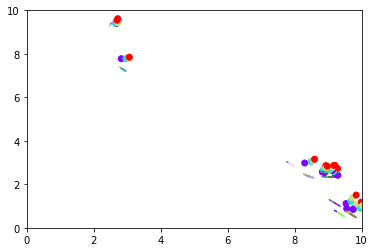

In [38]:
# now run the training!
# try to overfit a batch first...

INPUT_LENGTH = 8
OUTPUT_LENGTH = 4
TOTAL_LENGTH = INPUT_LENGTH + OUTPUT_LENGTH
BATCH_SIZE = 16

inp_ph,target_ph, model, params, loss = vanilla_lstm_model(128,
                                                           INPUT_LENGTH,
                                                           OUTPUT_LENGTH,
                                                          1e-3)
model.summary()
indices, input_batch, target_batch = get_batch(normalized_data,BATCH_SIZE,INPUT_LENGTH,OUTPUT_LENGTH)
# prepare data
input_batch_padded = np.hstack([input_batch,np.zeros((BATCH_SIZE,OUTPUT_LENGTH,2))])
target_batch_padded = np.hstack([np.zeros((BATCH_SIZE,INPUT_LENGTH,2)),target_batch])


# and train
model.fit(
    [input_batch_padded,target_batch_padded],
    [np.zeros((BATCH_SIZE,TOTAL_LENGTH,2)),np.zeros(BATCH_SIZE)],
    epochs = 500,
    callbacks = get_callbacks(input_batch_padded,target_batch_padded)
)

Epoch 1/500
16/16 [==============================] - 5s 330ms/step - loss: 0.0854 - predict_loss: 0.0000e+00 - loss_loss: 0.0854
Epoch 2/500
16/16 [==============================] - 1s 48ms/step - loss: 0.1401 - predict_loss: 0.0000e+00 - loss_loss: 0.1401
Epoch 3/500
16/16 [==============================] - 1s 41ms/step - loss: 0.0851 - predict_loss: 0.0000e+00 - loss_loss: 0.0851
Epoch 4/500
16/16 [==============================] - 1s 49ms/step - loss: 0.0847 - predict_loss: 0.0000e+00 - loss_loss: 0.0847
Epoch 5/500
16/16 [==============================] - 1s 47ms/step - loss: 0.0855 - predict_loss: 0.0000e+00 - loss_loss: 0.0855
Epoch 6/500
16/16 [==============================] - 1s 57ms/step - loss: 0.0852 - predict_loss: 0.0000e+00 - loss_loss: 0.0852
Epoch 7/500
16/16 [==============================] - 1s 59ms/step - loss: 0.0847 - predict_loss: 0.0000e+00 - loss_loss: 0.0847
Epoch 8/500
16/16 [==============================] - 1s 45ms/step - loss: 0.0843 - predict_loss: 0.0000

Epoch 65/500
16/16 [==============================] - 1s 54ms/step - loss: 0.0747 - predict_loss: 0.0000e+00 - loss_loss: 0.0747
Epoch 66/500
16/16 [==============================] - 1s 85ms/step - loss: 0.0750 - predict_loss: 0.0000e+00 - loss_loss: 0.0750
Epoch 67/500
16/16 [==============================] - 1s 72ms/step - loss: 0.0750 - predict_loss: 0.0000e+00 - loss_loss: 0.0750
Epoch 68/500
16/16 [==============================] - 1s 60ms/step - loss: 0.0749 - predict_loss: 0.0000e+00 - loss_loss: 0.0749
Epoch 69/500
16/16 [==============================] - 1s 57ms/step - loss: 0.0750 - predict_loss: 0.0000e+00 - loss_loss: 0.0750
Epoch 70/500
16/16 [==============================] - 1s 48ms/step - loss: 0.0751 - predict_loss: 0.0000e+00 - loss_loss: 0.0751
Epoch 71/500
16/16 [==============================] - 1s 50ms/step - loss: 0.0750 - predict_loss: 0.0000e+00 - loss_loss: 0.0750
Epoch 72/500
16/16 [==============================] - 1s 57ms/step - loss: 0.0745 - predict_loss:

Epoch 129/500
16/16 [==============================] - 1s 50ms/step - loss: 0.0648 - predict_loss: 0.0000e+00 - loss_loss: 0.0648
Epoch 130/500
16/16 [==============================] - 1s 71ms/step - loss: 0.0645 - predict_loss: 0.0000e+00 - loss_loss: 0.0645
Epoch 131/500
16/16 [==============================] - 1s 54ms/step - loss: 0.0643 - predict_loss: 0.0000e+00 - loss_loss: 0.0643
Epoch 132/500
16/16 [==============================] - 1s 57ms/step - loss: 0.0641 - predict_loss: 0.0000e+00 - loss_loss: 0.0641
Epoch 133/500
16/16 [==============================] - 2s 101ms/step - loss: 0.0641 - predict_loss: 0.0000e+00 - loss_loss: 0.0641
Epoch 134/500
16/16 [==============================] - 1s 55ms/step - loss: 0.0641 - predict_loss: 0.0000e+00 - loss_loss: 0.0641
Epoch 135/500
16/16 [==============================] - 1s 71ms/step - loss: 0.0645 - predict_loss: 0.0000e+00 - loss_loss: 0.0645
Epoch 136/500
16/16 [==============================] - 1s 61ms/step - loss: 0.0648 - pred

Epoch 192/500
16/16 [==============================] - 1s 61ms/step - loss: 0.0580 - predict_loss: 0.0000e+00 - loss_loss: 0.0580
Epoch 193/500
16/16 [==============================] - 1s 72ms/step - loss: 0.0583 - predict_loss: 0.0000e+00 - loss_loss: 0.0583
Epoch 194/500
16/16 [==============================] - 1s 59ms/step - loss: 0.0585 - predict_loss: 0.0000e+00 - loss_loss: 0.0585
Epoch 195/500
16/16 [==============================] - 1s 56ms/step - loss: 0.0583 - predict_loss: 0.0000e+00 - loss_loss: 0.0583
Epoch 196/500
16/16 [==============================] - 1s 50ms/step - loss: 0.0578 - predict_loss: 0.0000e+00 - loss_loss: 0.0578
Epoch 197/500
16/16 [==============================] - 1s 64ms/step - loss: 0.0572 - predict_loss: 0.0000e+00 - loss_loss: 0.0572
Epoch 198/500
16/16 [==============================] - 1s 69ms/step - loss: 0.0567 - predict_loss: 0.0000e+00 - loss_loss: 0.0567
Epoch 199/500
16/16 [==============================] - 1s 57ms/step - loss: 0.0564 - predi

16/16 [==============================] - 1s 60ms/step - loss: 0.0524 - predict_loss: 0.0000e+00 - loss_loss: 0.0524
Epoch 256/500
16/16 [==============================] - 1s 56ms/step - loss: 0.0522 - predict_loss: 0.0000e+00 - loss_loss: 0.0522
Epoch 257/500
16/16 [==============================] - 1s 57ms/step - loss: 0.0518 - predict_loss: 0.0000e+00 - loss_loss: 0.0518
Epoch 258/500
16/16 [==============================] - 1s 53ms/step - loss: 0.0515 - predict_loss: 0.0000e+00 - loss_loss: 0.0515
Epoch 259/500
16/16 [==============================] - 1s 65ms/step - loss: 0.0513 - predict_loss: 0.0000e+00 - loss_loss: 0.0513
Epoch 260/500
16/16 [==============================] - 1s 61ms/step - loss: 0.0512 - predict_loss: 0.0000e+00 - loss_loss: 0.0512
Epoch 261/500
16/16 [==============================] - 1s 59ms/step - loss: 0.0512 - predict_loss: 0.0000e+00 - loss_loss: 0.0512
Epoch 262/500
16/16 [==============================] - 1s 53ms/step - loss: 0.0513 - predict_loss: 0.000

16/16 [==============================] - 1s 63ms/step - loss: 0.0464 - predict_loss: 0.0000e+00 - loss_loss: 0.0464
Epoch 319/500
16/16 [==============================] - 1s 49ms/step - loss: 0.0463 - predict_loss: 0.0000e+00 - loss_loss: 0.0463
Epoch 320/500
16/16 [==============================] - 1s 48ms/step - loss: 0.0465 - predict_loss: 0.0000e+00 - loss_loss: 0.0465
Epoch 321/500
16/16 [==============================] - 1s 56ms/step - loss: 0.0472 - predict_loss: 0.0000e+00 - loss_loss: 0.0472
Epoch 322/500
16/16 [==============================] - 1s 67ms/step - loss: 0.0483 - predict_loss: 0.0000e+00 - loss_loss: 0.0483
Epoch 323/500
16/16 [==============================] - 2s 103ms/step - loss: 0.0489 - predict_loss: 0.0000e+00 - loss_loss: 0.0489
Epoch 324/500
16/16 [==============================] - 1s 52ms/step - loss: 0.0486 - predict_loss: 0.0000e+00 - loss_loss: 0.0486
Epoch 325/500
16/16 [==============================] - 1s 73ms/step - loss: 0.0482 - predict_loss: 0.00

16/16 [==============================] - 1s 55ms/step - loss: 0.0427 - predict_loss: 0.0000e+00 - loss_loss: 0.0427
Epoch 382/500
16/16 [==============================] - 1s 61ms/step - loss: 0.0424 - predict_loss: 0.0000e+00 - loss_loss: 0.0424
Epoch 383/500
16/16 [==============================] - 1s 80ms/step - loss: 0.0424 - predict_loss: 0.0000e+00 - loss_loss: 0.0424
Epoch 384/500
16/16 [==============================] - 1s 70ms/step - loss: 0.0428 - predict_loss: 0.0000e+00 - loss_loss: 0.0428
Epoch 385/500
16/16 [==============================] - 1s 58ms/step - loss: 0.0441 - predict_loss: 0.0000e+00 - loss_loss: 0.0441
Epoch 386/500
16/16 [==============================] - 1s 51ms/step - loss: 0.0463 - predict_loss: 0.0000e+00 - loss_loss: 0.0463
Epoch 387/500
16/16 [==============================] - 1s 62ms/step - loss: 0.0473 - predict_loss: 0.0000e+00 - loss_loss: 0.0473
Epoch 388/500
16/16 [==============================] - 2s 111ms/step - loss: 0.0455 - predict_loss: 0.00

16/16 [==============================] - 1s 51ms/step - loss: 0.0395 - predict_loss: 0.0000e+00 - loss_loss: 0.0395
Epoch 445/500
16/16 [==============================] - 1s 58ms/step - loss: 0.0393 - predict_loss: 0.0000e+00 - loss_loss: 0.0393
Epoch 446/500
16/16 [==============================] - 1s 72ms/step - loss: 0.0392 - predict_loss: 0.0000e+00 - loss_loss: 0.0392
Epoch 447/500
16/16 [==============================] - 1s 85ms/step - loss: 0.0392 - predict_loss: 0.0000e+00 - loss_loss: 0.0392
Epoch 448/500
16/16 [==============================] - 1s 63ms/step - loss: 0.0393 - predict_loss: 0.0000e+00 - loss_loss: 0.0393
Epoch 449/500
16/16 [==============================] - 1s 77ms/step - loss: 0.0395 - predict_loss: 0.0000e+00 - loss_loss: 0.0395
Epoch 450/500
16/16 [==============================] - 1s 91ms/step - loss: 0.0397 - predict_loss: 0.0000e+00 - loss_loss: 0.0397
Epoch 451/500
16/16 [==============================] - 1s 89ms/step - loss: 0.0396 - predict_loss: 0.000

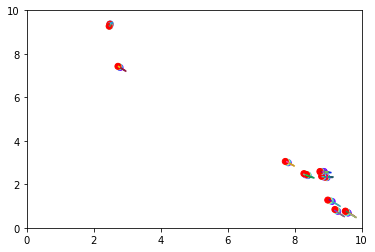

In [103]:
# finetuning
model.compile(optimizer=optimizers.RMSprop(lr = 1e-5, clipvalue = 10.),
              loss= {
                    'predict': lambda _, loss: loss - loss,
                      'loss': lambda _, loss: loss
                })
# and train
model.fit(
    [input_batch_padded,target_batch_padded],
    [np.zeros((BATCH_SIZE,TOTAL_LENGTH,2)),np.zeros(BATCH_SIZE)],
    epochs = 500,
    callbacks = get_callbacks(input_batch_padded,target_batch_padded, True)
)

In [104]:
'''
    Function that takes a "close" look of each tragectory
    Input:
        model: trained Keras model
        input: the batch of input of shape (N, input_length + target_length, 2)
        target: the batch of input of the same shape with input
        input_length: self-explanatory
    Output:
        Nothing, but generate N pictures of the plot with:
            target tragectories (should be input_length + target_length long) in black,
            predicted tragectories (shoudl be target_length long) in blue
'''
def close_visualize(model, input_batch,target_batch,input_length):
    if not input_batch.shape == target_batch.shape:
        raise ValueError("input batch and target batch should have the same size")
    batch_size,_,__ = input_batch.shape
    
    prediction, loss = model.predict([input_batch,target_batch])
    for batch_id in range(batch_size):
        # first clear the plot...
        plt.gcf().clear()
        
        # then retrieve the tragectories
        target_tragectories = target_batch[batch_id][input_length:]
        predicted_tragectories = prediction[batch_id]
        # evaluate the boundary to plot
        x_min = np.min(target_tragectories[:,0] - .1)
        x_max = np.max(target_tragectories[:,0] + .1)
        
        y_min = np.min(target_tragectories[:,1] - .1)
        y_max = np.max(target_tragectories[:,1] + .1)
        
        x_min_predicted = np.min(predicted_tragectories[:,0] - .1)
        x_max_predicted = np.max(predicted_tragectories[:,0] + .1)
        
        y_min_predicted = np.min(predicted_tragectories[:,1] - .1)
        y_max_predicted = np.max(predicted_tragectories[:,1] + .1)
        
        # set the boundary
        x_min = min(x_min,x_min_predicted)
        x_max = max(x_max,x_max_predicted)
        y_min = min(y_min,y_min_predicted)
        y_max = max(y_max,y_max_predicted)
        
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        # plot line...
        # first the target tragectories
#         plt.plot(target_tragectories[:,0],target_tragectories[:,1],c = 'black')
        # then the prediction
        for i in range(len(target_tragectories) - 1):
            cur_point = target_tragectories[i,:]
            next_point = target_tragectories[i + 1,:]
            plt.plot([cur_point[0],next_point[0]],[cur_point[1],next_point[1]],c = 'black')
            # and predicted...
            cur_point = predicted_tragectories[i,:]
            next_point = predicted_tragectories[i + 1,:]
            print(cur_point,next_point)
            plt.plot([cur_point[0],next_point[0]],[cur_point[1],next_point[1]],
                     c = 'blue',
                     linestyle = ':'
            )
#         plt.plot(predicted_tragectories[:,0],
#                   predicted_tragectories[:,1],
#                   linestyle = ':',
#                   c = 'blue')
        # then save the plot...
        plt.savefig('close-{}.png'.format(batch_id))

[9.129274  1.2102317] [9.081666  1.2347597]
[9.081666  1.2347597] [9.040708  1.2574404]
[9.040708  1.2574404] [9.002562  1.2729093]
[8.9769   2.304382] [8.960338 2.314553]
[8.960338 2.314553] [8.94669  2.319512]
[8.94669  2.319512] [8.927369  2.3255901]
[8.850335  2.5511096] [8.819266 2.549107]
[8.819266 2.549107] [8.805489  2.5491567]
[8.805489  2.5491567] [8.785894  2.5528386]
[8.886613  2.5878088] [8.849275  2.5819893]
[8.849275  2.5819893] [8.835579 2.580866]
[8.835579 2.580866] [8.815897  2.5833383]
[7.820026  2.9885628] [7.803195  3.0074983]
[7.803195  3.0074983] [7.773543  3.0232258]
[7.773543  3.0232258] [7.7370405 3.0484507]
[9.602262  0.6891499] [9.576425  0.7092054]
[9.576425  0.7092054] [9.548221  0.7454339]
[9.548221  0.7454339] [9.529905  0.7640031]
[9.294632   0.75532115] [9.277597  0.7840056]
[9.277597  0.7840056] [9.242183   0.81894505]
[9.242183   0.81894505] [9.216642  0.8413931]
[8.895726  2.5589657] [8.863403  2.5554442]
[8.863403  2.5554442] [8.851133 2.554605]
[8

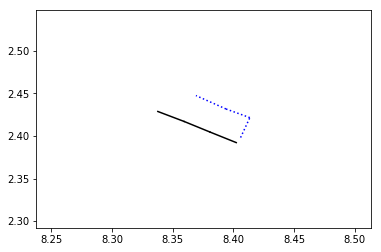

In [105]:
close_visualize(model,input_batch_padded,target_batch_padded,INPUT_LENGTH)